In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import os
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from tqdm.auto import tqdm as tq
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms, utils

import albumentations as alb

PATH = '../Desktop/pku/'
os.listdir(PATH)

['car_models_json',
 'test_images',
 'train_images',
 'train.csv',
 'train_masks',
 'car_models',
 'camera',
 'sample_submission.csv',
 'test_masks']

In [2]:
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'sample_submission.csv')

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)
camera_matrix_inv = np.linalg.inv(camera_matrix)

train.head()

,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2,ID_a381bf4d0,43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3,ID_7c4a3e0aa,43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4,ID_8b510fad6,37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...


In [3]:
corrupted_arr = ["ID_1a5a10365","ID_4d238ae90","ID_408f58e9f","ID_bb1d991f6","ID_c44983aeb"]
for _id in corrupted_arr:
    #plt.imshow( cv2.imread(PATH + 'train_images/' + _id + '.jpg')[:,:,::-1] )
    #plt.show()
    pass
print("before", len(train))
drop_train = train.set_index("ImageId").drop( index=corrupted_arr )
train = drop_train.reset_index()
print("after", len(train))

before 4262
after 4257


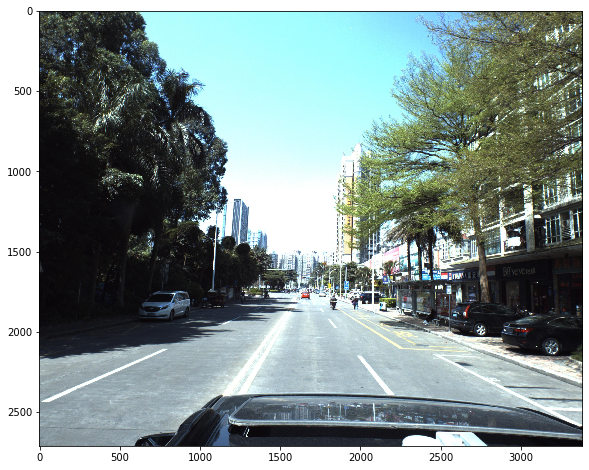

In [4]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

img = imread(PATH + 'train_images/ID_8a6e65317' + '.jpg')
IMG_SHAPE = img.shape

plt.figure(figsize=(15,8))
plt.imshow(img);


In [5]:
def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

In [6]:
inp = train['PredictionString'][0]
print('Example input:\n', inp)
print()
print('Output:\n', str2coords(inp))

Example input:
 16 0.254839 -2.57534 -3.10256 7.96539 3.20066 11.0225 56 0.181647 -1.46947 -3.12159 9.60332 4.66632 19.339 70 0.163072 -1.56865 -3.11754 10.39 11.2219 59.7825 70 0.141942 -3.1395 3.11969 -9.59236 5.13662 24.7337 46 0.163068 -2.08578 -3.11754 9.83335 13.2689 72.9323

Output:
 [{'id': 16, 'yaw': 0.254839, 'pitch': -2.57534, 'roll': -3.10256, 'x': 7.96539, 'y': 3.20066, 'z': 11.0225}, {'id': 56, 'yaw': 0.181647, 'pitch': -1.46947, 'roll': -3.12159, 'x': 9.60332, 'y': 4.66632, 'z': 19.339}, {'id': 70, 'yaw': 0.163072, 'pitch': -1.56865, 'roll': -3.11754, 'x': 10.39, 'y': 11.2219, 'z': 59.7825}, {'id': 70, 'yaw': 0.141942, 'pitch': -3.1395, 'roll': 3.11969, 'x': -9.59236, 'y': 5.13662, 'z': 24.7337}, {'id': 46, 'yaw': 0.163068, 'pitch': -2.08578, 'roll': -3.11754, 'x': 9.83335, 'y': 13.2689, 'z': 72.9323}]


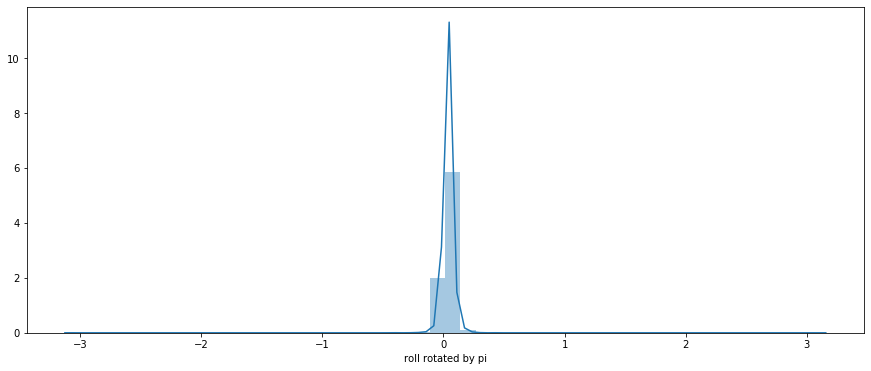

In [7]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x

plt.figure(figsize=(15,6))
sns.distplot(reduce(lambda a, b: a + b, [[rotate(c['roll'], np.pi) for c in str2coords(s)] for s in train['PredictionString']]));
plt.xlabel('roll rotated by pi')
plt.show()

In [8]:
def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

In [9]:
xs, ys = [], []

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

In [10]:
from math import sin, cos

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [11]:
def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
#         if p_x > image.shape[1] or p_y > image.shape[0]:
#             print('Point', p_x, p_y, 'is out of image with shape', image.shape)
    return image


In [12]:
def visualize(img, coords):
    # You will also need functions from the previous cells
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

In [13]:
ORIG_W = 3384
ORIG_H = 2710
# train image size

if True:  # ORIGINAL-SIZE
    IMG_WIDTH = 2048
    IMG_HEIGHT = 512  #IMG_WIDTH // 4
    MARGIN_W = ORIG_W // 4  # 846
else:  #this was bad
    IMG_WIDTH = 512*3  # 512*4==2048
    IMG_HEIGHT = 512
    MARGIN_W = ORIG_W//4

MODEL_SCALE = 8  # mask shrink rate

FX, FY = 2304.5479,  2305.8757
CX, CY = 1686.2379, 1354.9849
def XYZ2UV(x,y,z):
    u = FX * x / z + CX
    v = FY * y / z + CY
    return u,v
def UVZ2XY(u,v,z):
    x = z * (u - CX) / FX
    y = z * (v - CY) / FY
    return x,y

# OLD CODE #
#x, y = y, x
#x = (x - img.shape[0] // 2) * IMG_HEIGHT / (img.shape[0] // 2) / MODEL_SCALE
#x = np.round(x).astype('int')
#y = (y + img.shape[1] // 4) * IMG_WIDTH / (img.shape[1] * 1.5) / MODEL_SCALE
#y = np.round(y).astype('int')
def VU2maskVU(v,u):  # V:vertical, U:horizontal
    mask_V = (v - ORIG_H // 2) * IMG_HEIGHT / (ORIG_H // 2) / MODEL_SCALE
    mask_U = (u + MARGIN_W) * IMG_WIDTH  / (ORIG_W + 2*MARGIN_W) / MODEL_SCALE
    return mask_V, mask_U
def maskVU2VU(mask_v_float, mask_u_float):
    v = ORIG_H // 2 + mask_v_float * MODEL_SCALE / IMG_HEIGHT * (ORIG_H // 2)
    u = mask_u_float * MODEL_SCALE * (ORIG_W + 2*MARGIN_W) / IMG_WIDTH - MARGIN_W
    return v, u
## test code
#_v, _u = 2709, 1611
#_mv, _mu = VU2maskVU(_v, _u)
#print("v,u :", _v, _u)
#print("mask v,u :", _mv, _mu)
#print("v,u (backed) :", maskVU2VU( _mv, _mu ) )

## assertion usage
#REGR_TARGETS = sorted( ["x","y","z", "yaw","pitch_sin", "pitch_cos", "roll"] )
REGR_TARGETS = sorted( ["vdiff","udiff","z", "yaw","pitch_sin", "pitch_cos", "roll"] )
def _regr_preprocess(regr_dict, vdiff, udiff):
    """ vdiff(h orientation), udiff is regression target """
    regr_dict["vdiff"] = vdiff
    regr_dict["udiff"] = udiff

    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    # Pitch
    if False:  # regress pitch from car(camera)
        pitch_from_car = regr_dict['pitch'] + np.arctan(regr_dict['x'] / regr_dict['z']) # calc in radian
        regr_dict['pitch_sin'] = sin(pitch_from_car)
        regr_dict['pitch_cos'] = cos(pitch_from_car)
    else:  # regress world-pitch directly
        regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
        regr_dict['pitch_cos'] = cos(regr_dict['pitch'])

    # Regress log(Z)
    regr_dict["z"] = np.log(regr_dict["z"])
    
    regr_dict.pop('x')
    regr_dict.pop('y')
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict, mask_V_pos, mask_U_pos):
    # back log(z) to z
    regr_dict["z"] = np.exp(regr_dict["z"])

    _v, _u = maskVU2VU( mask_V_pos + regr_dict["vdiff"], mask_U_pos + regr_dict["udiff"] )
    regr_dict["x"], regr_dict["y"] = UVZ2XY(_u, _v, regr_dict["z"])

    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)

    ## Pitch
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    if False:
        # pitch from camera
        pitch_from_car = np.arccos(pitch_cos) * np.sign(pitch_sin)
        # back to real-workd pitch
        regr_dict['pitch'] = pitch_from_car - np.arctan(regr_dict["x"] / regr_dict["z"])
    else:
        regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :MARGIN_W]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return (img / 255).astype('float32')
def preprocess_mask_image(img):  # 上関数とといっしょに編集するように注意
    img = img[img.shape[0] // 2:]
    bg = np.zeros_like(img).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # lenear interpolate
    return (img / 255).astype('float32')

# https://github.com/xingyizhou/CenterNet/blob/819e0d0dde02f7b8cb0644987a8d3a370aa8206a/src/lib/utils/image.py
# heatmap: H, W
# center : X(w direction), Y(H direction)
##################### mu_x = int(center[0] + 0.5) CAUSES BUG ##################################
def old_draw_msra_gaussian(heatmap, center, sigma):
    tmp_size = sigma * 3
    mu_x = int(center[0] + 0.5)
    mu_y = int(center[1] + 0.5)
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap
def draw_msra_gaussian(heatmap, center, sigma):
    # tmp_size = sigma * 3
    tmp_size = np.ceil(sigma * 3).astype(int)  # tmp_size should be int for readability ( and to remove bug ? )
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    return heatmap

def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
    diameter = 2 * radius + 1
    gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
    
    x, y = int(center[0]), int(center[1])

    height, width = heatmap.shape[0:2]
      
    left, right = min(x, radius), min(width - x, radius + 1)
    top, bottom = min(y, radius), min(height - y, radius + 1)

    masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
    masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
    if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
        np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
    return heatmap

def make_heatmap(m, v_arr, u_arr, z_arr):
    for v,u,z in zip(v_arr, u_arr, z_arr):
        # sigma = 1000 / 3.  / z / MODEL_SCALE
        sigma = 800 / 3.  / z / MODEL_SCALE
        m = draw_msra_gaussian(m, (u,v), sigma)
    return m
        
#def get_mask_and_regr(img, labels):
#    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
#    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
#    coords = str2coords(labels)
#    xs, ys = get_img_coords(labels)
#    z_arr = [e["z"] for e in coords]
#    
#    mask_V_arr_float, mask_U_arr_float = VU2maskVU( ys, xs )
#    # use floor floowing paper
#    mask_V_arr = np.floor( mask_V_arr_float ).astype('int')
#    mask_U_arr = np.floor( mask_U_arr_float ).astype('int')
#    mask_V_diff = mask_V_arr_float - mask_V_arr
#    mask_U_diff = mask_U_arr_float - mask_U_arr
#
#    # make heatmap
#    mask = make_heatmap(mask, mask_V_arr, mask_U_arr, z_arr)
#    
#    for mask_V,mask_U, vdiff,udiff, regr_dict in zip(mask_V_arr,mask_U_arr,mask_V_diff,mask_U_diff, coords):
#        if mask_V >= 0 and mask_V < IMG_HEIGHT // MODEL_SCALE and mask_U >= 0 and mask_U < IMG_WIDTH // MODEL_SCALE:
#            regr_dict = _regr_preprocess(regr_dict, vdiff, udiff)
#            regr[mask_V, mask_U] = [regr_dict[n] for n in sorted(regr_dict)]
#    return mask, regr
def get_mask_and_regr(img, labels, aug=False):
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    z_arr = [e["z"] for e in coords]
    
    mask_V_arr_float, mask_U_arr_float = VU2maskVU( ys, xs )
    if aug:
        VU_JITTER_MIN = 0.3
        ###VU_JITTER = np.maximum(VU_JITTER_MIN,   2 * (800./ np.array(z_arr) / 3.) / MODEL_SCALE)  # jitter diameter = sigma
        VU_JITTER = np.maximum(VU_JITTER_MIN,   2 * (800. / 3. / np.array(z_arr) / MODEL_SCALE) / 3.  )  # jitter diameter = sigma/2
        mask_V_arr_float += VU_JITTER * ( np.random.rand(len(mask_V_arr_float)) - 0.5)
        mask_U_arr_float += VU_JITTER * ( np.random.rand(len(mask_U_arr_float)) - 0.5)

    # use floor floowing paper
    mask_V_arr = np.floor( mask_V_arr_float ).astype('int')
    mask_U_arr = np.floor( mask_U_arr_float ).astype('int')
    mask_V_diff = mask_V_arr_float - mask_V_arr
    mask_U_diff = mask_U_arr_float - mask_U_arr

    # make heatmap
    mask = make_heatmap(mask, mask_V_arr, mask_U_arr, z_arr)
    
    for mask_V,mask_U, vdiff,udiff, regr_dict in zip(mask_V_arr,mask_U_arr,mask_V_diff,mask_U_diff, coords):
        if mask_V >= 0 and mask_V < IMG_HEIGHT // MODEL_SCALE and mask_U >= 0 and mask_U < IMG_WIDTH // MODEL_SCALE:
            regr_dict = _regr_preprocess(regr_dict, vdiff, udiff)
            regr[mask_V, mask_U] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

In [14]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, mask_root_dir, training=True, data_aug=False):
        self.df = dataframe
        self.root_dir = root_dir
        self.mask_root_dir = mask_root_dir  # ignore mask
        self.training = training
        self.data_aug = data_aug
        if data_aug:
            self.data_aug_func = train_aug_trasforms = alb.Compose([
                alb.RandomBrightnessContrast(0.05, 0.05, p=0.2),
                alb.GaussNoise(var_limit=(10.0, 50.0), p=0.1),
            ], p=1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        ## Read image
        #img0 = imread(img_name, True)  #old
        img0 = cv2.imread(img_name)[:,:,::-1]
        if self.data_aug:
            img0 = self.data_aug_func(image=img0)["image"]
        img = preprocess_image(img0.astype(float))
        img = np.rollaxis(img, 2, 0)
        
        ## Read ignore mask
        #ign_img0 = imread(self.mask_root_dir.format(idx), True)
        #do not resize, just use it# ign_img = preprocess_mask_image(ign_img0)
        ign_img0 = cv2.imread(self.mask_root_dir.format(idx), cv2.IMREAD_GRAYSCALE)
        if ign_img0 is None:  # some pics has NO MASK
            ign_img0 = np.zeros((ORIG_H, ORIG_W), dtype='float32')

        ign_img = np.array(ign_img0).astype('float32') / 255.
        # ign_img = np.rollaxis(ign_img, 2, 0)
        ######################################################

        # ignore mask for CNN
        ign_img_for_feed = preprocess_mask_image(ign_img0)
        ign_img_for_feed = np.expand_dims(ign_img_for_feed, 0)  # h,w -> 1,h,w
        
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img0, labels, self.data_aug)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        return [img, mask, regr, ign_img, ign_img_for_feed]

In [15]:
train_images_dir = PATH + 'train_images/{}.jpg'
test_images_dir = PATH + 'test_images/{}.jpg'
train_masks_dir = PATH + 'train_masks/{}.jpg'
test_masks_dir = PATH + 'test_masks/{}.jpg'

### df_train, df_dev = train_test_split(train, test_size=0.01, random_state=42)
df_train, df_dev = train_test_split(train, test_size=0.1, random_state=1042)
df_test = test

## Create dataset objects
train_dataset = CarDataset(df_train, train_images_dir, train_masks_dir, data_aug=True)
###train_dataset = CarDataset(df_train, train_images_dir, train_masks_dir, data_aug=False)
dev_dataset = CarDataset(df_dev, train_images_dir, train_masks_dir)
test_dataset = CarDataset(df_test, test_images_dir, test_masks_dir)

In [16]:
if False:  # for data aug test
    img, mask, regr, ign_mask, ign_mask_for_feed = train_dataset[81]
    plt.figure(figsize=(40,40))
    plt.imshow(np.rollaxis(img, 0, 3))
    plt.show()
    cv2.imwrite("a.png", np.rollaxis(img, 0, 3) * 255)
if False:    
    img, mask, regr, ign_mask, ign_mask_for_feed = train_dataset[50]
    plt.figure(figsize=(40,40))
    plt.imshow(np.rollaxis(img, 0, 3))
    plt.show()

In [17]:
BATCH_SIZE = 1

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [18]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.GroupNorm(16, planes)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.GroupNorm(16, planes)

        if stride != 1 or inplanes != planes:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes, stride), nn.GroupNorm(16, planes))
        else:
            self.downsample = None


    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out, inplace=True)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.GroupNorm(16, planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.GroupNorm(16, planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.GroupNorm(16, planes * self.expansion)

        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                conv1x1(inplanes, planes * self.expansion, stride), 
                nn.GroupNorm(16, planes * self.expansion))
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = F.relu(self.bn2(self.conv2(out)), inplace=True)
        out = self.bn3(self.conv3(out))
 
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


class ResNetFeatures(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, input_channels=3):
        super(ResNetFeatures, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.GroupNorm(16, 64)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):

        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        conv1 = F.relu(self.bn1(self.conv1(x)), inplace=True)
        conv1 = F.max_pool2d(conv1, 3, stride=2, padding=1)

        feats4 = self.layer1(conv1)
        feats8 = self.layer2(feats4)
        feats16 = self.layer3(feats8)
        feats32 = self.layer4(feats16)

        return feats8, feats16, feats32



def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet18']))
    return model



def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetFeatures(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        _load_pretrained(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def _load_pretrained(model, pretrained):
    model_dict = model.state_dict()
    pretrained = {k : v for k, v in pretrained.items() if k in model_dict}
    model_dict.update(pretrained)
    model.load_state_dict(model_dict)

In [20]:
USEMASK = True

class CentResnet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(CentResnet, self).__init__()
        self.base_model = resnet18(pretrained=False, input_channels=6)
        
        # Lateral layers convert resnet outputs to a common feature size
        self.lat8 = nn.Conv2d(128, 256, 1)
        self.lat16 = nn.Conv2d(256, 256, 1)
        self.lat32 = nn.Conv2d(512, 256, 1)
        self.bn8 = nn.GroupNorm(16, 256)
        self.bn16 = nn.GroupNorm(16, 256)
        self.bn32 = nn.GroupNorm(16, 256)

        if USEMASK:
            self.conv0 = double_conv(5 + 1, 64)
        else:
            self.conv0 = double_conv(5, 64)
            
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 , 512) #+ 1024
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)
        
    
    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        #feats = self.base_model.extract_features(x)
                # Run frontend network
        if USEMASK:
            ## feats8, feats16, feats32 = self.base_model(x[:,0:3])  ## use first 3 channel. this may not be proper way
            feats8, feats16, feats32 = self.base_model(x0)  ## C=6 : rgb(3)+mask(1)+mesh(2)
        else:
            feats8, feats16, feats32 = self.base_model(x)

        lat8 = F.relu(self.bn8(self.lat8(feats8)))
        lat16 = F.relu(self.bn16(self.lat16(feats16)))
        lat32 = F.relu(self.bn32(self.lat32(feats32)))
        
        # Add positional info
        mesh2 = get_mesh(batch_size, lat32.shape[2], lat32.shape[3])
        feats = torch.cat([lat32, mesh2], 1)
        #print(feats.shape)
        #print (x4.shape)
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [21]:
## Constants
SWITCH_LOSS_EPOCH = -1 # 5
n_epochs = 20  # 12 #6

# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = CentResnet(8).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0009)
### optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)

EPOCH_STEPS = 1 * len(train_loader)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

##exp_lr_scheduler = lr_scheduler. MultiStepLR(optimizer, 
#   milestones=[int(EPOCH_STEPS*6), int(EPOCH_STEPS*10)], gamma=0.1)  #6.4.2
#    milestones=[int(EPOCH_STEPS*10)], gamma=0.1)  #
#    milestones=[int(EPOCH_STEPS*100)], gamma=0.5)  # constant LR
#    milestones=[int(EPOCH_STEPS*9), int(EPOCH_STEPS*15)], gamma=0.1)  # 9.6.2
#    milestones=[int(EPOCH_STEPS*6), int(EPOCH_STEPS*10)], gamma=0.1)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, min_lr=1e-3*1e-3, factor=1./9.)

cuda


In [22]:
if USEMASK:
    img_batch = torch.randn((1,3 + 1,512,2048))
else:
    img_batch = torch.randn((1,3,512,2048))

In [23]:
#test = model(img_batch.to(device))

In [23]:
def infer_image(img, ign_mask_for_feed):  # shape:[B,C,H,W]
    return model( torch.from_numpy( np.concatenate((img, ign_mask_for_feed),axis=1) ).to(device) )

In [24]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

######## def postprocess_heatmap(logits, thresh=0.60):  # V6+ignMask, LB0.062
######## def postprocess_heatmap(logits, thresh=0.50):  # V6+ignMask, LB0.066
######## def postprocess_heatmap(logits, thresh=0.40):  # V6+ignMask, LB0.065
######## def postprocess_heatmap(logits, thresh=0.30):  # V6+ignMask, LB0.063

### def postprocess_heatmap(logits, thresh=0.4):
def postprocess_heatmap(logits, thresh=0.45):
    prob = sigmoid(logits)
    mp2d = torch.nn.MaxPool2d(3, stride=1, padding=1, dilation=1, return_indices=False, ceil_mode=False)
    out = mp2d( torch.Tensor([[prob]]) ).numpy()[0][0]
    return (prob == out) & (prob > thresh)

In [25]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # stolen from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - IMG_SHAPE[0] // 2) * IMG_HEIGHT / (IMG_SHAPE[0] // 2) / MODEL_SCALE
        x = np.round(x).astype('int')
        y = (y + IMG_SHAPE[1] // 4) * IMG_WIDTH / (IMG_SHAPE[1] * 1.5) / MODEL_SCALE
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2

    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, ign_mask):
    assert ign_mask.shape[0] == ORIG_H   #
    logits = prediction[0]
    regr_output = prediction[1:]
    ##OLD simple threthold### points = np.argwhere(logits > 0)
    points_mat = postprocess_heatmap(logits) 
    points = np.argwhere( points_mat > 0 )
    
    # OLD # col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    col_names = sorted(REGR_TARGETS)  # vdiff,udiff,z,yaw,pitch_sin,pitch_cos,roll
    coords = []
    for r, c in points:           
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        
        # use heatmap-peak (V,U) position
        regr_backed = _regr_back(regr_dict, r, c)
        
        _U, _V = XYZ2UV(regr_backed["x"], regr_backed["y"], regr_backed["z"])
        _U, _V = int(_U), int(_V)
        if _V>=0 and _V<ORIG_H and _U>=0 and _U<ORIG_W and ign_mask[_V,_U] > 0.5:  # floor(u), floor(v)
            # print("point is in ignore_mask")
            continue

        coords.append(regr_backed)
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        #coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
        ## V4: r,c is now floor(float val of mask_UV ), so add 0.5
        ## V5: do not do optmizer()
        # coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r+0.5, c+0.5, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])

        coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)

In [27]:
#MAP Calculation

In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import sqrt, acos, pi, sin, cos
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import average_precision_score
from multiprocessing import Pool
import functools

def expand_df(df, PredictionStringCols):
    df = df.dropna().copy()
    df['NumCars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]

    #image_id_expanded = [item for item, count in zip(df['ImageId'], df['NumCars']) for i in range(count)]
    ##prediction_strings_expanded = df['PredictionString'].str.split(' ',expand = True).values.reshape(-1,7).astype(float)
    ##prediction_strings_expanded = prediction_strings_expanded[~np.isnan(prediction_strings_expanded).all(axis=1)]

    assert len(PredictionStringCols) == 7
    idarr = []
    tmparr = []
    for imgid, predstr in zip( df['ImageId'], df['PredictionString']):
        if predstr == "":
            continue
        coords = np.array(predstr.split(' ')).reshape(-1,7).astype(float)
        for cor in coords:
            idarr.append(imgid)
            tmparr.append(  cor.tolist() )
    
    prediction_strings_expanded = np.array(tmparr)
    df = pd.DataFrame(
        {
#            'ImageId': image_id_expanded,
            'ImageId': idarr,
            PredictionStringCols[0]:prediction_strings_expanded[:,0],
            PredictionStringCols[1]:prediction_strings_expanded[:,1],
            PredictionStringCols[2]:prediction_strings_expanded[:,2],
            PredictionStringCols[3]:prediction_strings_expanded[:,3],
            PredictionStringCols[4]:prediction_strings_expanded[:,4],
            PredictionStringCols[5]:prediction_strings_expanded[:,5],
            PredictionStringCols[6]:prediction_strings_expanded[:,6]
        })
    return df

def str2coords_dev(s, names):
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
    return coords

def TranslationDistance(p,g, abs_dist = False):
    dx = p['x'] - g['x']
    dy = p['y'] - g['y']
    dz = p['z'] - g['z']
    diff0 = (g['x']**2 + g['y']**2 + g['z']**2)**0.5
    diff1 = (dx**2 + dy**2 + dz**2)**0.5
    if abs_dist:
        diff = diff1
    else:
        diff = diff1/diff0
    return diff

def RotationDistance(p, g):
    true=[ g['pitch'] ,g['yaw'] ,g['roll'] ]
    pred=[ p['pitch'] ,p['yaw'] ,p['roll'] ]
    q1 = R.from_euler('xyz', true)
    q2 = R.from_euler('xyz', pred)
    diff = R.inv(q2) * q1
    W = np.clip(diff.as_quat()[-1], -1., 1.)
    
    # in the official metrics code:
    # https://www.kaggle.com/c/pku-autonomous-driving/overview/evaluation
    #   return Object3D.RadianToDegree( Math.Acos(diff.W) )
    # this code treat θ and θ+2π differntly.
    # So this should be fixed as follows.
    W = (acos(W)*360)/pi
    if W > 180:
        W = 360 - W
    return W

In [27]:
thres_tr_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
thres_ro_list = [50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

def check_match(train_df, valid_df, idx):  # train_df==TrueLabel, valid_df==Prediction
    keep_gt=False
    thre_tr_dist = thres_tr_list[idx]
    thre_ro_dist = thres_ro_list[idx]
    train_dict = {imgID:str2coords_dev(s, names=['carid_or_score', 'pitch', 'yaw', 'roll', 'x', 'y', 'z']) for imgID,s in zip(train_df['ImageId'],train_df['PredictionString'])}
    valid_dict = {imgID:str2coords_dev(s, names=['pitch', 'yaw', 'roll', 'x', 'y', 'z', 'carid_or_score']) for imgID,s in zip(valid_df['ImageId'],valid_df['PredictionString'])}
    result_flg = [] # 1 for TP, 0 for FP
    scores = []
    MAX_VAL = 10**10
    for img_id in valid_dict:
        for pcar in sorted(valid_dict[img_id], key=lambda x: -x['carid_or_score']):
            # find nearest GT
            min_tr_dist = MAX_VAL
            min_idx = -1
            for idx, gcar in enumerate(train_dict[img_id]):
                tr_dist = TranslationDistance(pcar,gcar)
                if tr_dist < min_tr_dist:
                    min_tr_dist = tr_dist
                    min_ro_dist = RotationDistance(pcar,gcar)
                    min_idx = idx
                    
            # set the result
            if min_tr_dist < thre_tr_dist and min_ro_dist < thre_ro_dist:
                if not keep_gt:
                    train_dict[img_id].pop(min_idx)
                result_flg.append(1)
            else:
                result_flg.append(0)
            scores.append(pcar['carid_or_score'])
    
    return result_flg, scores

In [28]:
_train_df = pd.read_csv('../Desktop/pku/train.csv')

def calc_map(valid_df):
    if np.all( valid_df.dropna().PredictionString == "" ):  # no pred
        #print("warn: no prediction")
        return 0.0

    expanded_valid_df = expand_df(valid_df, ['pitch','yaw','roll','x','y','z','Score'])

    val_label_df = _train_df[_train_df.ImageId.isin(valid_df.ImageId.unique())]
    # data description page says, The pose information is formatted as
    # model type, yaw, pitch, roll, x, y, z
    # but it doesn't, and it should be
    # model type, pitch, yaw, roll, x, y, z
    expanded_val_label_df = expand_df(val_label_df, ['model_type','pitch','yaw','roll','x','y','z'])

    n_gt = len(expanded_val_label_df)
    ap_list = []

    ###max_workers = 10
    ###p = Pool(processes=max_workers)
    ###for result_flg, scores in p.imap(eval_func, range(10)):

    eval_func = functools.partial(check_match, val_label_df, valid_df)

    for _i in range(10):
        result_flg, scores = eval_func(_i)

        n_tp = np.sum(result_flg)
        recall = n_tp/n_gt

        ### randomized score version
        ### https://www.kaggle.com/c/pku-autonomous-driving/discussion/124489
        # ap = average_precision_score(result_flg, scores)*recall
        if False:
            ap = average_precision_score(result_flg, np.random.rand(len(result_flg)))*recall
        else: # pure precision * recall
            ap = np.mean(result_flg) * recall
            # print(f"precision/recall/F1 {np.mean(result_flg)}/{recall}/{ap}")
        ap_list.append(ap)

    return np.mean(ap_list)

def trim_below_threth(CV_df, threth):
    cc = CV_df.copy()

    tmparr = []
    for st in cc.PredictionString:
        if st == "":
            tmparr.append("")
        else:
            r = np.array([float(e) for e in st.split(" ")]).reshape(-1,7)
            r = r[ r[:,6] >= threth, :]
            tmparr.append( " ".join( [ str(e) for e in r.flatten()] ) )
    cc.PredictionString = tmparr
    return cc

In [31]:
##Training

In [29]:
# binary mask
def _criterion_old(prediction, mask, regr,weight=0.4, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

def criterion_old2(prediction, heatmap, regr,weight=0.4, size_average=True):
    mask = torch.eq(heatmap, 1)

    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    ### Loss of original paper
    mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - heatmap)**4 * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)

    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = weight*mask_loss +(1-weight)* regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss ,mask_loss , regr_loss

def criterion(prediction, heatmap, regr, regr_weight=1., mask_weight=0.5):
    mask = torch.eq(heatmap, 1)

    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
#     mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    ### Loss of original paper
    mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - heatmap)**4 * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)

    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
  
    # Sum
    loss = mask_weight * mask_loss + regr_weight * regr_loss
    return loss ,mask_loss , regr_loss


In [30]:
## Just for checking the shapes to manage our Unet
i = 0
for batch_idx, (img_batch, mask_batch, regr_batch, ign_mask_batch, ign_mask_for_feed_batch) in enumerate(tqdm(train_loader)):
#for batch_idx, (img_batch, mask_batch, regr_batch, ign_mask_batch) in enumerate(tqdm(train_loader)):
#for batch_idx, (img_batch, mask_batch, regr_batch, ign_mask_batch) in enumerate(tqdm(test_loader)):
    print(img_batch.shape)
    print(mask_batch.shape)
    print(regr_batch.shape)
    print(ign_mask_batch.shape)
    print(ign_mask_for_feed_batch.shape)
    i+=1
    if i>1:
        break

torch.Size([1, 3, 512, 2048])
torch.Size([1, 64, 256])
torch.Size([1, 7, 64, 256])
torch.Size([1, 2710, 3384])
torch.Size([1, 1, 512, 2048])
torch.Size([1, 3, 512, 2048])
torch.Size([1, 64, 256])
torch.Size([1, 7, 64, 256])
torch.Size([1, 2710, 3384])
torch.Size([1, 1, 512, 2048])


In [31]:
# Load ready to prediction model
# model.load_state_dict(torch.load('../Documents/model_epoch_19.pth'))

<All keys matched successfully>

In [35]:
def train_one(epoch, history=None):
    model.train()
    print('Train Epoch: {} \tLR: {:.6f}'.format(epoch, optimizer.state_dict()['param_groups'][0]['lr']))
    t = tqdm(train_loader)
    for batch_idx, (img_batch, mask_batch, regr_batch, ign_mask_batch, ign_mask_for_feed_batch) in enumerate(t):
        #img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        if USEMASK:
            output = infer_image(img_batch, ign_mask_for_feed_batch)
        else:
            output = model(img_batch)

        if epoch < SWITCH_LOSS_EPOCH :
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch, regr_weight=0.1, mask_weight=0.9)
            #loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch, 0.9)  # # 0 weight may degrate weight at switch
            # loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch,0.95) 
        else:
            loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch)
        
        t.set_description(f'train_loss (l={loss:.3f})(m={mask_loss:.2f}) (r={regr_loss:.4f}')
        
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
            history.loc[epoch + batch_idx / len(train_loader), 'train_mask_loss'] = mask_loss.data.cpu().numpy()
            history.loc[epoch + batch_idx / len(train_loader), 'train_regr_loss'] = regr_loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        ################ TRY ReduceLROnPlateau ################ exp_lr_scheduler.step()
    
    print('  TrainLoss: {:.4f}\tMaskLoss: {:.4f}\tRegLoss: {:.4f}'.format(
        history.query(f"index >= {epoch}").train_loss.mean(),
        history.query(f"index >= {epoch}").train_mask_loss.mean(),
        history.query(f"index >= {epoch}").train_regr_loss.mean() ))
#        loss.data,
#        mask_loss.data,
#        regr_loss.data))

def evaluate(epoch, history=None):
    model.eval()
    loss = 0
    valid_loss = 0
    valid_mask_loss = 0
    valid_regr_loss = 0
    dev_predictions = []  # for mAP calc

    with torch.no_grad():
        for img_batch, mask_batch, regr_batch, ign_mask_batch, ign_mask_for_feed_batch in dev_loader:
            #img_batch = img_batch.to(device)

            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            ##old#output = model(img_batch)
            ##img_batch_withmask = torch.from_numpy( np.concatenate( (img_batch, ign_mask_for_feed_batch), axis=1 ) ).to(device)
            ##output = model(img_batch_withmask)
            output = infer_image(img_batch, ign_mask_for_feed_batch)

            if epoch < SWITCH_LOSS_EPOCH :
                loss,mask_loss, regr_loss= criterion(output, mask_batch, regr_batch, regr_weight=0.1, mask_weight=0.9)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data
            else :
                loss,mask_loss, regr_loss = criterion(output, mask_batch, regr_batch)
                valid_loss += loss.data
                valid_mask_loss += mask_loss.data
                valid_regr_loss += regr_loss.data

            for out, ign_mask in zip(output.data.cpu().numpy(), ign_mask_batch):  # for mAP calc
                coords = extract_coords(out, ign_mask)
                s = coords2str(coords)
                dev_predictions.append(s)        

    # calc mean of losses
    valid_loss /= len(dev_loader)
    valid_mask_loss /= len(dev_loader)
    valid_regr_loss /= len(dev_loader)

    ################ TRY ReduceLROnPlateau
    exp_lr_scheduler.step(valid_loss)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = valid_loss.cpu().numpy()
        history.loc[epoch, 'mask_loss'] = valid_mask_loss.cpu().numpy()
        history.loc[epoch, 'regr_loss'] = valid_regr_loss.cpu().numpy()

    if True:
        CV_dev = pd.DataFrame()
        CV_dev["ImageId"] = df_dev.ImageId.copy()
        CV_dev['PredictionString'] = dev_predictions
        mapval = calc_map(CV_dev)
        history.loc[epoch, 'map'] = mapval

    print('    DevLoss: {:.4f}\tMaskLoss: {:.4f}\tRegLoss: {:.4f}\tmAP: {:.6f}'.format(
            valid_loss, valid_mask_loss, valid_regr_loss, mapval))

In [ ]:
%%time
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    train_one(epoch, history)
    evaluate(epoch, history)
    if epoch >= 10:
        torch.save(model.state_dict(), f'./model_epoch_{epoch}.pth')

Train Epoch: 0 	LR: 0.000900



  TrainLoss: 12.1464	MaskLoss: 20.8558	RegLoss: 1.7186
    DevLoss: 7.5410	MaskLoss: 12.3446	RegLoss: 1.3687	mAP: 0.021594
Train Epoch: 1 	LR: 0.000900



  TrainLoss: 6.5280	MaskLoss: 10.3609	RegLoss: 1.3476
    DevLoss: 5.5308	MaskLoss: 8.6405	RegLoss: 1.2106	mAP: 0.043824
Train Epoch: 2 	LR: 0.000900



  TrainLoss: 5.3730	MaskLoss: 8.4016	RegLoss: 1.1722
    DevLoss: 4.8584	MaskLoss: 7.5426	RegLoss: 1.0871	mAP: 0.065712
Train Epoch: 3 	LR: 0.000900



  TrainLoss: 4.7837	MaskLoss: 7.4412	RegLoss: 1.0631
    DevLoss: 4.4578	MaskLoss: 6.9267	RegLoss: 0.9945	mAP: 0.089320
Train Epoch: 4 	LR: 0.000900



  TrainLoss: 4.3695	MaskLoss: 6.7617	RegLoss: 0.9886
    DevLoss: 4.0710	MaskLoss: 6.2872	RegLoss: 0.9274	mAP: 0.099686
Train Epoch: 5 	LR: 0.000900



  TrainLoss: 4.0487	MaskLoss: 6.2475	RegLoss: 0.9249
    DevLoss: 3.9353	MaskLoss: 6.0750	RegLoss: 0.8978	mAP: 0.100987
Train Epoch: 6 	LR: 0.000900



  TrainLoss: 3.7892	MaskLoss: 5.8009	RegLoss: 0.8888
    DevLoss: 3.7510	MaskLoss: 5.8016	RegLoss: 0.8502	mAP: 0.113949
Train Epoch: 7 	LR: 0.000900



  TrainLoss: 3.5485	MaskLoss: 5.3859	RegLoss: 0.8556
    DevLoss: 3.7428	MaskLoss: 5.8102	RegLoss: 0.8377	mAP: 0.103444
Train Epoch: 8 	LR: 0.000900



  TrainLoss: 3.3275	MaskLoss: 4.9890	RegLoss: 0.8330
    DevLoss: 3.7301	MaskLoss: 5.8207	RegLoss: 0.8198	mAP: 0.108214
Train Epoch: 9 	LR: 0.000900



  TrainLoss: 3.1106	MaskLoss: 4.5988	RegLoss: 0.8112
    DevLoss: 3.6983	MaskLoss: 5.8062	RegLoss: 0.7952	mAP: 0.123054
Train Epoch: 10 	LR: 0.000900



  TrainLoss: 2.8985	MaskLoss: 4.2076	RegLoss: 0.7947
    DevLoss: 3.8180	MaskLoss: 6.0473	RegLoss: 0.7944	mAP: 0.105504
Train Epoch: 11 	LR: 0.000900



  TrainLoss: 2.7053	MaskLoss: 3.8524	RegLoss: 0.7791


/home/rubn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


    DevLoss: 3.8633	MaskLoss: 6.1254	RegLoss: 0.8006	mAP: 0.109741
Train Epoch: 12 	LR: 0.000900



  TrainLoss: 2.5229	MaskLoss: 3.5144	RegLoss: 0.7657
Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
    DevLoss: 3.9630	MaskLoss: 6.3593	RegLoss: 0.7834	mAP: 0.131749
Train Epoch: 13 	LR: 0.000100



  TrainLoss: 1.9908	MaskLoss: 2.5783	RegLoss: 0.7016
    DevLoss: 4.3642	MaskLoss: 7.2385	RegLoss: 0.7450	mAP: 0.140411
Train Epoch: 14 	LR: 0.000100



  TrainLoss: 1.8150	MaskLoss: 2.2650	RegLoss: 0.6825
    DevLoss: 4.6126	MaskLoss: 7.7381	RegLoss: 0.7435	mAP: 0.149385
Train Epoch: 15 	LR: 0.000100



  TrainLoss: 1.7417	MaskLoss: 2.1402	RegLoss: 0.6716
Epoch    15: reducing learning rate of group 0 to 1.1111e-05.
    DevLoss: 4.8282	MaskLoss: 8.1745	RegLoss: 0.7410	mAP: 0.148427
Train Epoch: 16 	LR: 0.000011


In [ ]:
torch.save(model.state_dict(), './model.pth')

In [36]:
history['train_loss'].iloc[100:].plot();

In [37]:
plt.figure(figsize=(10,10))

labels = ['train_loss', 'train_mask_loss', "train_regr_loss"]
tr_logs = history[labels].dropna()
losses_arr = [ tr_logs.query(f"index > {_e} & index < {_e+1}").mean().values for _e in range(n_epochs)]
tr_logs_arr = np.array( losses_arr ).T

plt.plot(tr_logs_arr[0],   "r--",label=labels[0])
plt.plot(tr_logs_arr[1],   "b--",label=labels[1])
plt.plot(tr_logs_arr[2]*10,"g--" ,label=labels[2] +" *10")

series3 = history.dropna()['dev_loss']
series1 = history.dropna()['mask_loss']
series2 = history.dropna()['regr_loss']
series4 = history.dropna()['map']

plt.plot(series3.index, series3   , "r", label = 'dev loss');
plt.plot(series1.index, series1   , "b", label = 'mask loss');
plt.plot(series2.index, series2*10, "g", label = 'regr loss');

plt.plot(series2.index, series4*100,  "k", label = 'mAP*100');

plt.plot()

plt.grid(True)
plt.legend()

plt.xticks(range(100))
plt.yticks(range(100))
plt.xlim(0,n_epochs)
plt.ylim(0,20)

plt.savefig("Loss.jpg")
plt.show()

NameError: name 'history' is not defined

<Figure size 720x720 with 0 Axes>

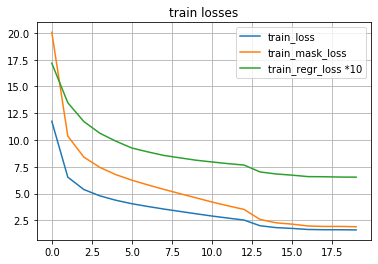

In [39]:
labels = ['train_loss', 'train_mask_loss', "train_regr_loss"]
tr_logs = history[labels].dropna()
losses_arr = [ tr_logs.query(f"index > {_e} & index < {_e+1}").mean().values for _e in range(n_epochs)]
tr_logs_arr = np.array( losses_arr ).T

plt.plot(tr_logs_arr[0], label=labels[0])
plt.plot(tr_logs_arr[1], label=labels[1])
plt.plot(tr_logs_arr[2] * 10, label=labels[2] +" *10")
plt.title("train losses")
plt.grid()
plt.legend()
plt.savefig("Loss_Train.jpg")
plt.show()

In [38]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 10*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.grid(True)
plt.legend()
plt.savefig("Loss_Val_all.jpg")
plt.show()

NameError: name 'history' is not defined

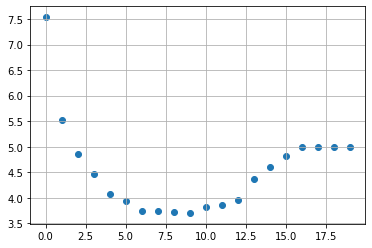

In [41]:
series = history.dropna()['dev_loss']
history[['dev_loss','mask_loss','regr_loss','map']].dropna().to_csv("./dev_loss.csv")
plt.grid(True)
plt.scatter(series.index, series);
plt.savefig("Loss_Val.jpg")
plt.show()

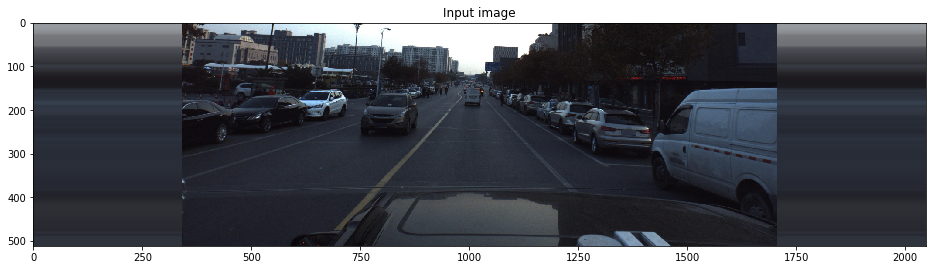

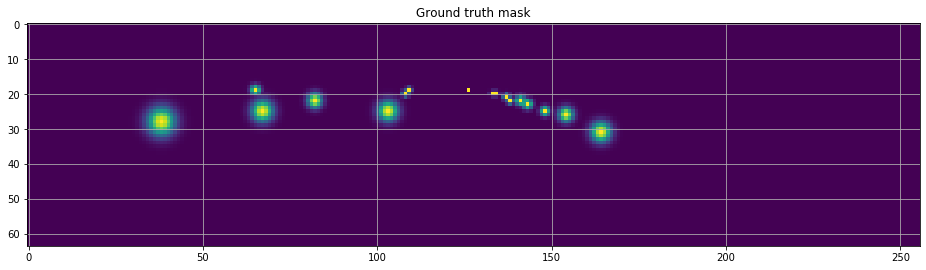

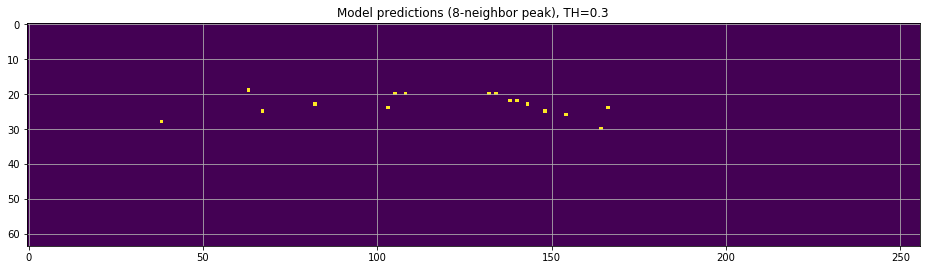

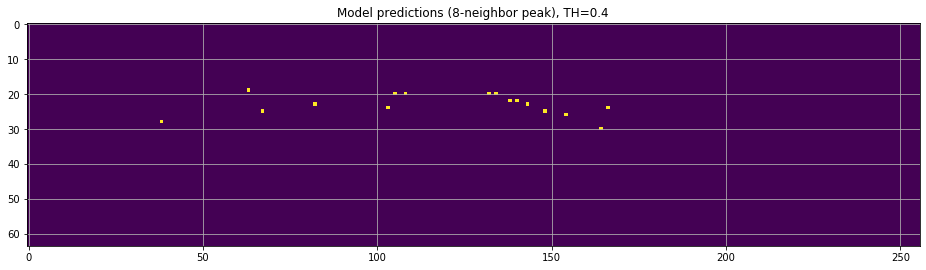

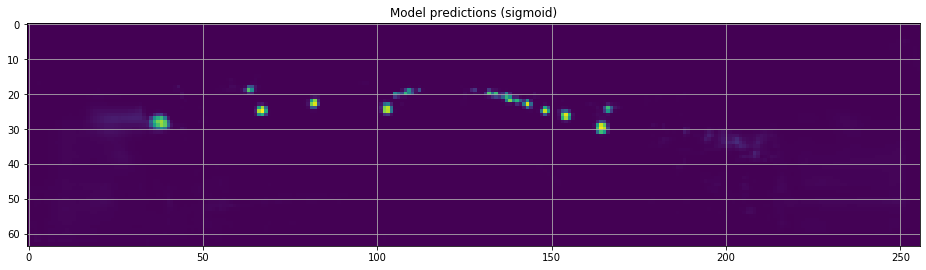

In [42]:
img, mask, regr, ign_mask, ign_mask_for_feed = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.grid()
plt.imshow(mask)
plt.show()

if USEMASK:
    output = infer_image(img[None], ign_mask_for_feed[None])
else:
    output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions (8-neighbor peak), TH=0.3')
plt.grid()
plt.imshow(postprocess_heatmap( logits, thresh=0.3 ))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions (8-neighbor peak), TH=0.4')
plt.grid()
plt.imshow(postprocess_heatmap( logits, thresh=0.4 ))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions (sigmoid)')
plt.grid()
plt.imshow(sigmoid(logits))
plt.show()

#print(logits)
#plt.figure(figsize=(16,16))
#plt.title('Model predictions (simple) thresholded')
#plt.imshow(logits > 0)
#plt.show()

In [43]:
## Simple test of probabilities
act = torch.nn.Sigmoid()
logtens = torch.from_numpy(logits)
probs = act(logtens)
probs = probs[probs>0.03]
print(probs)

tensor([0.0344, 0.2805, 0.2358, 0.0504, 0.1294, 0.6921, 0.4693, 0.0384, 0.1624,
        0.4722, 0.1592, 0.0437, 0.2149, 0.0843, 0.1472, 0.1642, 0.0405, 0.0302,
        0.1093, 0.0854, 0.4348, 0.3039, 0.2054, 0.6174, 0.4126, 0.2310, 0.0321,
        0.1353, 0.6781, 0.3657, 0.6336, 0.0836, 0.1193, 0.4080, 0.0874, 0.0470,
        0.0307, 0.1444, 0.0734, 0.0333, 0.1154, 0.1917, 0.1327, 0.2929, 0.6236,
        0.4815, 0.0712, 0.0790, 0.0311, 0.5209, 0.7760, 0.1128, 0.4106, 0.7574,
        0.4237, 0.6063, 0.2762, 0.1267, 0.4438, 0.0568, 0.0485, 0.0635, 0.0467,
        0.7542, 0.8967, 0.2181, 0.0463, 0.3223, 0.4023, 0.0923, 0.1042, 0.0514,
        0.3878, 0.8948, 0.3305, 0.0607, 0.0300, 0.0425, 0.5493, 0.8225, 0.3265,
        0.2486, 0.2539, 0.0851, 0.7585, 0.8551, 0.3386, 0.0535, 0.3331, 0.1199,
        0.0404, 0.5636, 0.2191, 0.2151, 0.6494, 0.2727, 0.0507, 0.0315, 0.0321,
        0.0319, 0.0317, 0.0323, 0.0324, 0.0320, 0.0326, 0.0331, 0.0338, 0.0351,
        0.0414, 0.0484, 0.0780, 0.8299, 

In [51]:
torch.cuda.empty_cache()

In [52]:
gc.collect()

for idx in range(8):
    img, heatmap, regr, ign_mask, ign_mask_for_feed = dev_dataset[idx]
    mask = (heatmap >= 1).astype(float)
    if False: #debug
        print(regr.shape)
        print(heatmap.shape)
        print( REGR_TARGETS )
        print(np.where(heatmap == 1))
        print(np.where(regr[-1] > 0))
        print(regr[ -1 ][heatmap >= 1] )
        raise
    
    if USEMASK:
        output = infer_image(img[None], ign_mask_for_feed[None])
        output = output.data.cpu().numpy()
    else:
        output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()

    coords_pred = extract_coords(output[0], ign_mask)
    
    perfect_logits = 1000 * ( ( heatmap==1 ).astype(float) - 0.5 )
    coords_true = extract_coords(np.concatenate([perfect_logits[None], regr], 0), ign_mask)
    
    img = imread(train_images_dir.format(df_dev['ImageId'].iloc[idx]))
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.93 GiB total capacity; 7.31 GiB already allocated; 4.19 MiB free; 82.98 MiB cached)

In [39]:
predictions = []

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=4)
#test_loader = DataLoader(dataset=test_dataset, batch_size=2, shuffle=False, num_workers=2)

model.eval()

for img, _, _, ign_masks, ign_mask_for_feed_batch in tqdm(test_loader):
    with torch.no_grad():
        if USEMASK:
            output = infer_image(img, ign_mask_for_feed_batch)
        else:
            output = model(img.to(device))
    output = output.data.cpu().numpy()
    #for out in output:
    for out, ign_mask in zip(output, ign_masks):
        coords = extract_coords(out, ign_mask)
        s = coords2str(coords)
        predictions.append(s)

/home/rubn/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [40]:
test = pd.read_csv(PATH + 'sample_submission.csv')
test['PredictionString'] = predictions
# test.to_csv('predictions.csv', index=False)
test.to_csv('predictions-f.csv', index=False)
test.head()

,ImageId,PredictionString
0,ID_18fb86d04,
1,ID_ce06d4dc1,0.14114249 -0.28678384248518124 -3.10357350681...
2,ID_afe07078f,0.14580928 -0.0324673078605251 -3.102922057854...
3,ID_37caf75aa,0.1427134 -0.03274280026493691 -3.092651980119...
4,ID_7655363ca,0.15026459 3.1256319985909347 -3.1225809977673...
